*WORK IN PROGRESS*

Install Libraries.

In [100]:
import pandas as pd
import yfinance as yf # type: ignore
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime as dt
from datetime import timedelta

Load Data.

In [101]:
# tickers_ = ['SPY','NKE']
SPY_df = yf.download(tickers='SPY', auto_adjust=False)
# NKE_df = yf.download(tickers='NKE', auto_adjust=False)
INTC_df = yf.download(tickers='INTC', auto_adjust=False)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [102]:
logreturns = np.log(SPY_df['Adj Close']) - np.log(SPY_df['Adj Close'].shift(1))
SPY_df['LogReturns'] = logreturns

In [103]:
logreturns = np.log(INTC_df['Adj Close']) - np.log(INTC_df['Adj Close'].shift(1))
INTC_df['LogReturns'] = logreturns

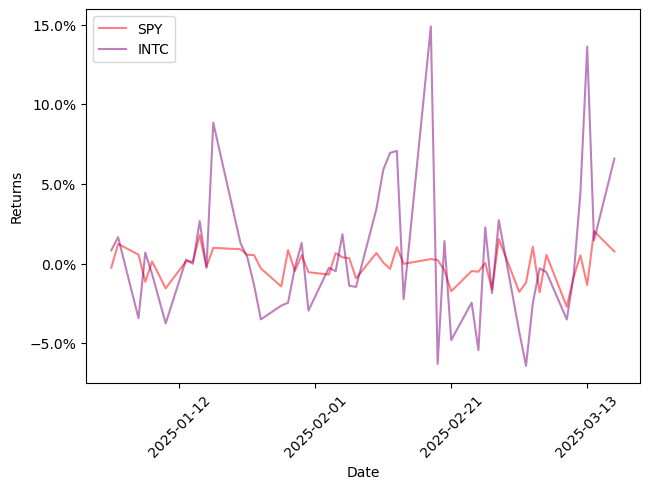

In [104]:
start_date, end_date = '2025-01-01', '2025-03-17'
plt.plot(SPY_df.loc[start_date:end_date,'LogReturns']*(100), color='red',label='SPY',alpha=0.5);
plt.plot(INTC_df.loc[start_date:end_date,'LogReturns']*(100), color='purple', label='INTC',alpha=0.5);
plt.legend();

plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.tight_layout()

plt.xlabel('Date');
plt.ylabel('Returns');

# Strategy 1 - Z-Score Mean Reversion

In [105]:
start_ = '2010-01-01'
end_ = dt.datetime.today()
data = yf.download('SPY', start=start_, end=end_, auto_adjust=False)

cols = data.columns
data_dict = {tuple_[0]:[] for tuple_ in cols}
for tuple_ in cols:
    data_dict[tuple_[0]] = [data[tuple_[0]].values[i][0] for i in range(len(data[tuple_[0]].values))]

SPY_df = pd.DataFrame(data_dict)
SPY_df.index = np.array(data.index)
SPY_df

[*********************100%***********************]  1 of 1 completed


,Adj Close,Close,High,Low,Open,Volume
2010-01-04,86.026497,113.330002,113.389999,111.510002,112.370003,118944600
2010-01-05,86.254158,113.629997,113.680000,112.849998,113.260002,111579900
2010-01-06,86.314911,113.709999,113.989998,113.430000,113.519997,116074400
2010-01-07,86.679253,114.190002,114.330002,113.180000,113.500000,131091100
2010-01-08,86.967682,114.570000,114.620003,113.660004,113.889999,126402800
...,...,...,...,...,...,...
2025-03-11,555.919983,555.919983,564.020020,552.020020,559.400024,88102100
2025-03-12,558.869995,558.869995,563.109985,553.690002,562.169983,69588200
2025-03-13,551.419983,551.419983,559.109985,549.679993,558.489990,74079400
2025-03-14,562.809998,562.809998,563.830017,551.489990,556.109985,62660300


In [106]:
window = 20 # hyperparameter we can tune later in backtesting
SPY_df['Rolling_Mean'] = SPY_df['Close'].rolling(window=window).mean() # rolling mean
SPY_df['Rolling_STD'] = SPY_df['Close'].rolling(window=window).std() # rolling standard deviation

Since $Z = (X - E[X])/\sigma_X$, we can calculate the Z-Scores as follows using our rolling mean and rolling standard deviation.

In [107]:
SPY_df['Z-Score'] = (SPY_df['Adj Close'] - SPY_df['Rolling_Mean']) / SPY_df['Rolling_STD']

In [145]:
tao = 0.5
SPY_df['Decision'] = 0
SPY_df.loc[SPY_df['Z-Score'] > tao, 'Decision'] = -1  # Sell when Z-score > 1 -> SPY is overbought
SPY_df.loc[SPY_df['Z-Score'] < -tao, 'Decision'] = 1  # Buy when Z-score < -1 SPY is oversold
                                                      #Decision == 0 -> hold current position.

Lets backtest this on 10-years, 5-years, 2-years, 1-year, 6-months of data and calculate the PnL.

In [146]:
yrs = 1
today = dt.datetime.today()
start = today - timedelta(days=365 * yrs)
df = SPY_df.loc[start:today]
df = df.reset_index(drop=False).rename(columns = {'index':'Date'})
df

,Date,Adj Close,Close,High,Low,Open,Volume,Rolling_Mean,Rolling_STD,Z-Score,Decision
0,2024-03-18,507.937988,512.859985,515.479980,512.440002,514.000000,88893300,509.342996,5.369410,-0.261669,0
1,2024-03-19,510.760681,515.710022,516.000000,511.119995,512.150024,60755300,510.290497,4.656817,0.100967,0
2,2024-03-20,515.484863,520.479980,520.619995,515.080017,515.770020,69594600,511.453996,4.089038,0.985774,-1
3,2024-03-21,517.188354,522.200012,524.109985,521.909973,523.390015,60256100,512.188997,4.626711,1.080543,-1
4,2024-03-22,516.207825,521.210022,522.609985,520.969971,522.109985,79023000,512.856998,4.922292,0.680745,-1
...,...,...,...,...,...,...,...,...,...,...,...
245,2025-03-11,555.919983,555.919983,564.020020,552.020020,559.400024,88102100,591.843997,17.076225,-2.103745,1
246,2025-03-12,558.869995,558.869995,563.109985,553.690002,562.169983,69588200,589.521997,18.264820,-1.678199,1
247,2025-03-13,551.419983,551.419983,559.109985,549.679993,558.489990,74079400,586.924997,19.820052,-1.791368,1
248,2025-03-14,562.809998,562.809998,563.830017,551.489990,556.109985,62660300,584.578998,19.755408,-1.101926,1


In [147]:
df['Decision'].values

array([ 0,  0, -1, -1, -1,  0,  0, -1,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  0,  0,
        1,  0,  1,  1, -1,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,
        1,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  0,  1,
        1,  1,  1,  1,  0,  0,  0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1,
        0,  0,  0, -1,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
        0,  0,  0,  0,  0,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1, -1,  0,
        0,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1,
        0,  0, -1,  0,  1,  1,  1,  1,  0,  0,  1,  1,  1,  1,  1,  0,  1,
        1,  1,  1,  1,  0,  0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,
       -1, -1, -1,  0, -1

In [150]:
proportion = 0.05 #proportion of assets purchased in Decision (BUY/SELL)
Balance = [10000] #10k
Shares = [0]
pnl = [Balance]

for i in range(1,df.shape[0]):
    if df.loc[i-1,'Decision'] == 1: #BUY 
        shares_ = (Balance[-1]*proportion)/df.loc[i-1,'Adj Close']
        Balance.append(Balance[-1] - Balance[-1]*proportion)
        Shares.append(shares_ + Shares[-1])

        #See net gains
        share_net = df.loc[i,'Adj Close'] - df.loc[i-1,'Adj Close']
        pnl.append(pnl[-1] + share_net*shares_)
    
    elif df.loc[i-1,'Decision'] == -1: #SELL 
        shares_ = (Balance[-1]*proportion)/df.loc[i-1,'Adj Close']
        Balance.append(Balance[-1] + Balance[-1]*proportion)
        Shares.append(shares_ - Shares[-1])

        #See net gains
        shares_ = df.loc[i,'Adj Close'] - df.loc[i-1,'Adj Close']
        pnl.append(pnl[-1] + share_net*shares_)


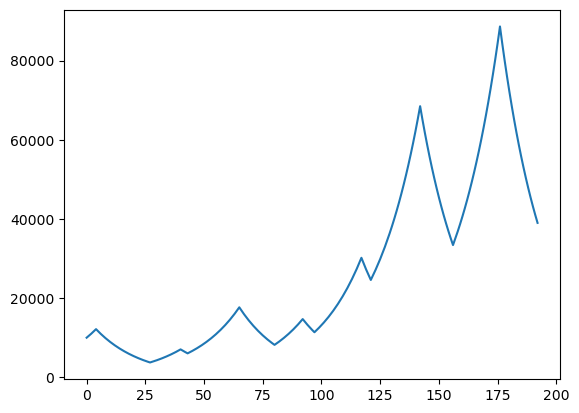

In [151]:
plt.plot(Balance)

ValueError: Input could not be cast to an at-least-1D NumPy array

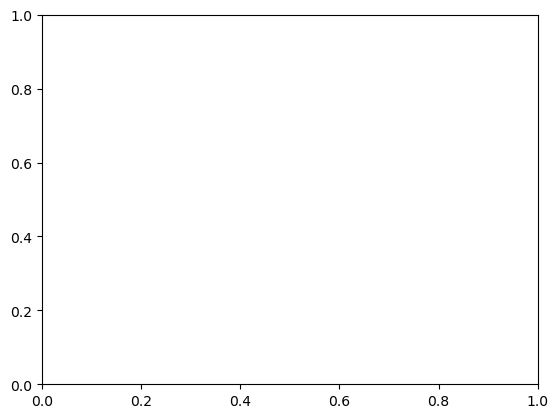

In [152]:
plt.plot(pnl)